# Objective

In April of 2015 the 7.8 magnitude Gorkha earthquake occured near the Gorkha district of Gandaki Pradesh, Nepal. Almost 9,000 lives were lost, millions of people were instantly made homeless, and $10 billion in damages––about half of Nepal's nominal GDP––were incurred. In the years since, the Nepalese government has worked intensely to help rebuild the affected districts' infrastructures. Throughout this process, the National Planning Commission, along with Kathmandu Living Labs and the Central Bureau of Statistics, has generated, One of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.

Our goal is to predict the level of damage a building suffered as a result of the 2015 earthquake. The data comes from the 2015 Nepal Earthquake Open Data Portal, and mainly consists of information on the buildings' structure and their legal ownership. Each row in the dataset represents a specific building in the region that was hit by Gorkha earthquake.

We are predicting the level of damage from 1 to 3. The level of damage is an ordinal variable meaning that ordering is important. This can be viewed as a classification or an ordinal regression problem.

## Library Imports

In [32]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

In [33]:
# Using the Path to get the location of datasets
DATA_DIR = Path('..', '..', '..', 'LargeDatasets', 'DrivenData', 'Richters')
DATA_DIR

WindowsPath('../../../LargeDatasets/DrivenData/Richters')

## Load the dataset and validate the dataload

In [29]:
# Load both the training features and training labels

train_features = pd.read_csv(DATA_DIR/'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR/'train_labels.csv', index_col='building_id')

In [34]:
# We will also load the test_features
test_features = pd.read_csv(DATA_DIR/'test_values.csv', index_col='building_id')

In [4]:
# Check few initial rows of the dataset
train_features.head(3)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Check few intial rows of the test attributes
test_features.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Check the first 3 rows of the training labels
train_labels.head(3)

,damage_grade
building_id,
802906,3
28830,2
94947,3


In [6]:
# Check the structure of the features
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [36]:
# Check the structure of the test features
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 300051 to 501372
Data columns (total 38 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   geo_level_1_id                          86868 non-null  int64 
 1   geo_level_2_id                          86868 non-null  int64 
 2   geo_level_3_id                          86868 non-null  int64 
 3   count_floors_pre_eq                     86868 non-null  int64 
 4   age                                     86868 non-null  int64 
 5   area_percentage                         86868 non-null  int64 
 6   height_percentage                       86868 non-null  int64 
 7   land_surface_condition                  86868 non-null  object
 8   foundation_type                         86868 non-null  object
 9   roof_type                               86868 non-null  object
 10  ground_floor_type                       86868 non-null  object
 

In [40]:
# Check for missing values in training features
sum(train_features.isna().sum())

0

In [41]:
# Check for missing values in test features
sum(test_features.isna().sum())

0

## Data Exploration and Visualization

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64


<AxesSubplot:xlabel='damage_grade', ylabel='count'>

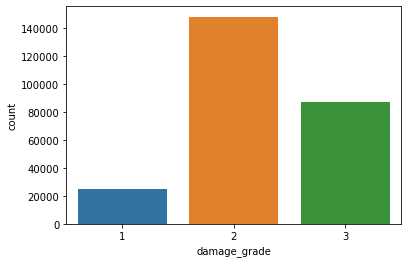

In [8]:
# Explore the target variable

print(train_labels['damage_grade'].value_counts())
sns.countplot(x='damage_grade', data=train_labels)

### Exploratory Analysis using DTale

In [9]:
import dtale

# Perform the exploration
dtale.show(train_features)

### Some feature transformations

In [23]:
# Transforming Label Transformations
label_encoder = LabelEncoder()

# Encode labels
train_features['land_surface_condition'] = label_encoder.fit_transform(train_features['land_surface_condition'])
train_features['foundation_type'] = label_encoder.fit_transform(train_features['foundation_type'])
train_features['roof_type'] = label_encoder.fit_transform(train_features['roof_type'])
train_features['ground_floor_type'] = label_encoder.fit_transform(train_features['ground_floor_type'])
train_features['other_floor_type'] = label_encoder.fit_transform(train_features['other_floor_type'])
train_features['position'] = label_encoder.fit_transform(train_features['position'])
train_features['plan_configuration'] = label_encoder.fit_transform(train_features['plan_configuration'])
train_features['legal_ownership_status'] = label_encoder.fit_transform(train_features['legal_ownership_status'])

In [12]:
# Check few rows after transformation
train_features.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,2,2,0,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,1,2,0,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,2,2,0,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,2,2,0,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,2,2,0,...,0,0,0,0,0,0,0,0,0,0


## Perform Train-Test Split

In [13]:
X = train_features
y = train_labels['damage_grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)                                                                                                                                   

## Scaling the feature set

In [14]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Building the Model - Random Forest

In [16]:
# Imports
from sklearn.ensemble import RandomForestClassifier

In [17]:
# we will pass few hyperparameters in Grid for execution

param_grid = {'n_estimators': [50, 100, 200],
             'max_depth': [3, 4, 5],
             'criterion': ['gini', 'entropy'],
             'max_features': ["auto", "sqrt", "log2"],
             'bootstrap': [True, False]}

rfc_grid = GridSearchCV(RandomForestClassifier(random_state=101), param_grid=param_grid, cv=5, n_jobs=-2, verbose=1)

In [18]:
# Train the model
start = datetime.now()
rfc_grid.fit(X_train, y_train)
end = datetime.now()
print(f"The training of model completed in time - {end - start}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
The training of model completed in time - 0:20:01.546471


In [19]:
# Check the best params
rfc_grid.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 50}

In [20]:
predictionsRFC = rfc_grid.predict(X_test)

print("Confusion Matrix\n")
print(confusion_matrix(y_test,predictionsRFC))
print("\n")
print("Classification Report \n")
print(classification_report(y_test,predictionsRFC))
print("\n")
print("Accuracy Score \n")
print(accuracy_score(y_test, predictionsRFC))
print("\n")
print("F1 Score \n")
print(f1_score(y_test, predictionsRFC, average='micro'))

Confusion Matrix

[[  982  4039     1]
 [  503 29016   362]
 [   17 15840  1361]]


Classification Report 

              precision    recall  f1-score   support

           1       0.65      0.20      0.30      5022
           2       0.59      0.97      0.74     29881
           3       0.79      0.08      0.14     17218

    accuracy                           0.60     52121
   macro avg       0.68      0.42      0.39     52121
weighted avg       0.66      0.60      0.50     52121



Accuracy Score 

0.6016576811649815


F1 Score 

0.6016576811649815


### Preparing RFC Submission

## Building the Model - Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

gaussianNBClassifier = GaussianNB()
gaussianNBClassifier.fit(X_train, y_train)

In [ ]:
predictionsGaussianNB = gaussianNBClassifier.predict(X_test)
print("Confusion Matrix - GaussianNB")
print(confusion_matrix(y_test, predictionsGaussianNB))
print("\n")
print("Accuracy Score - GaussianNB")
print(accuracy_score(y_test, predictionsGaussianNB))
print("\n")
print("Classification Report - GaussianNB")
print(classification_report(y_test, predictionsGaussianNB))
print("F1 Score \n")
print(f1_score(y_test, predictionsGaussianNB, average='micro'))

## Building the Model - XGBoost Classifier

In [ ]:

from xgboost import XGBClassifier

param_grid = {'n_estimators':[50, 100, 200, 300], 'max_depth' : [3, 4, 5], 'learning_rate':[0.001, 0.01, 0.1, 1, 10]}
xggrid = GridSearchCV(XGBClassifier(), param_grid, verbose=1, cv=5, n_jobs=-2)

In [ ]:
# Train the model
start = datetime.now()
xggrid.fit(X_train, y_train)
end = datetime.now()
print(f"The training of model completed in time - {end - start}")

In [ ]:
# Check the best params
xggrid.best_params_

In [ ]:
xggrid_predictions = xggrid.predict(X_test)

print("Confusion Matrix")
print(confusion_matrix(y_test, xggrid_predictions))
print("\n")
print("Accuracy Score")
print(accuracy_score(y_test, xggrid_predictions))
print("\n")
print("Classification Report")
print(classification_report(y_test, xggrid_predictions))
print("F1 Score \n")
print(f1_score(y_test, xggrid_predictions, average='micro'))

## Building the Model - Neural Network

In [ ]:
import tensorflow as tf

In [ ]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print("No GPU Available, switching to CPU Version")

In [ ]:
# Define some global model constants